In [1]:
%matplotlib inline

## Setup

In [2]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

## Dataset

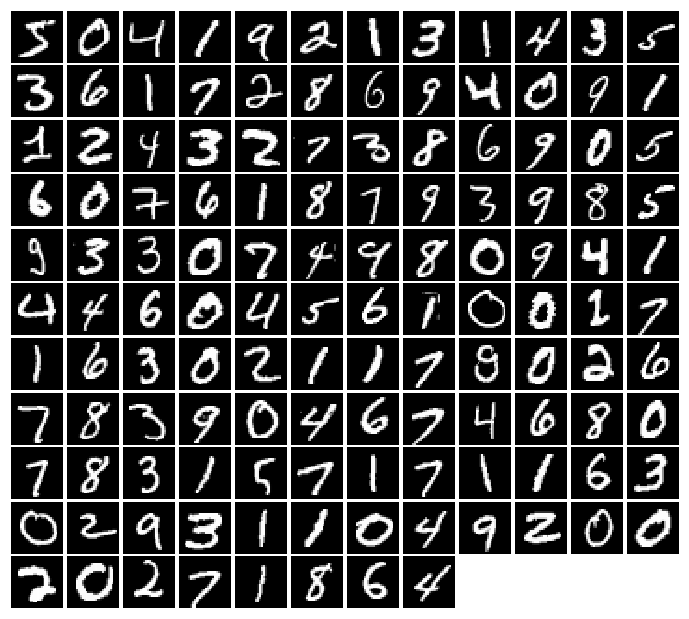

In [3]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST('./datasets/MNIST/', 
                         train=True, 
                         download=True,
                         transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./datasets/MNIST/',
                       train=True, 
                       download=True,
                       transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Random Noise

In [4]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    noise = torch.rand(batch_size, dim) * 2 - 1
    return noise

## Flatten

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

## CPU / GPU

In [6]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print('using device:', device)

using device: cuda


## Vanilla GAN

In [7]:
def discriminator():
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
        Flatten(),
        nn.Linear(784, 256),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Linear(256, 256),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Linear(256, 1),
    )
    return model

def generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 784),
        nn.Tanh(),
    )
    return model

def bce_loss(input_, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input_.abs()
    loss = input_.clamp(min=0) - input_ * target + (1 + neg_abs.exp()).log()
    return loss.mean()

from torch.autograd import Variable


def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    # Batch size.
    N = logits_real.size()
    
    # Target label vector, the discriminator should be aiming
    true_labels = torch.ones(N, requires_grad=True).type(dtype)
    
    # Discriminator loss has 2 parts: how well it classifies real images and how well it
    # classifies fake images.
    real_image_loss = bce_loss(logits_real, true_labels)
    fake_image_loss = bce_loss(logits_fake, 1 - true_labels)
    
    loss = real_image_loss + fake_image_loss
    
    return loss


def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    # Batch size.
    N = logits_fake.size()
    
    # Generator is trying to make the discriminator output 1 for all its images.
    # So we create a 'target' label vector of ones for computing generator loss.
    true_labels = torch.ones(N, requires_grad=True).type(dtype)
    
    # Compute the generator loss compraing 
    loss = bce_loss(logits_fake, true_labels)
    return loss

def optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    return optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999))


In [8]:
def gan_train(D, G, 
              D_solver, G_solver, 
              discriminator_loss, generator_loss, 
              show_every=250, 
              batch_size=128, 
              noise_size=96, 
              num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = x.type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

Iter: 0, D: 1.36, G:0.7137


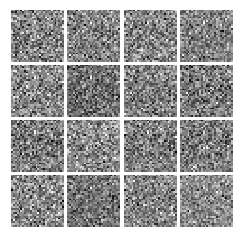


Iter: 250, D: 1.676, G:0.7991


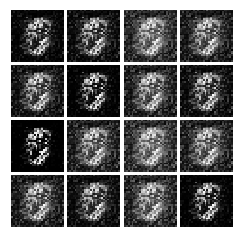


Iter: 500, D: 1.195, G:1.433


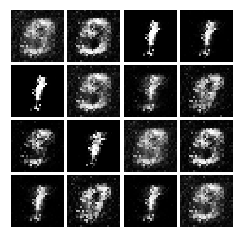


Iter: 750, D: 1.298, G:0.9668


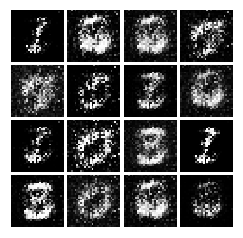


Iter: 1000, D: 1.191, G:1.068


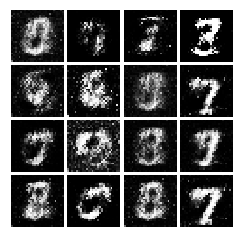


Iter: 1250, D: 1.425, G:0.8544


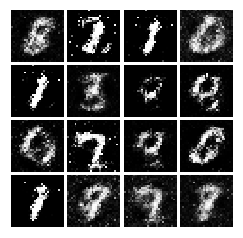


Iter: 1500, D: 1.247, G:0.9437


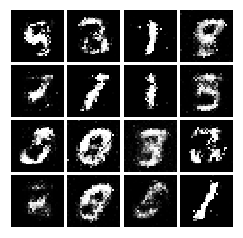


Iter: 1750, D: 1.307, G:0.9712


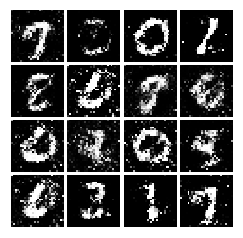


Iter: 2000, D: 1.327, G:0.8984


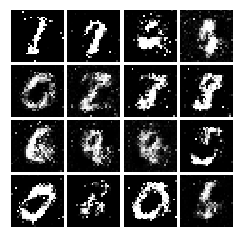


Iter: 2250, D: 1.3, G:0.8286


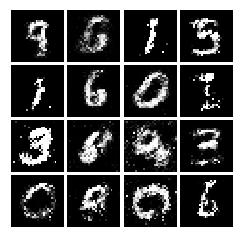


Iter: 2500, D: 1.302, G:0.8263


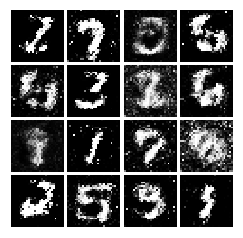


Iter: 2750, D: 1.291, G:0.8814


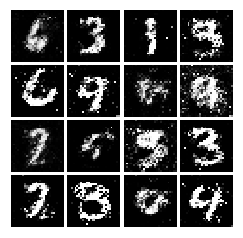


Iter: 3000, D: 1.379, G:0.8311


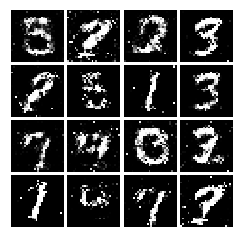


Iter: 3250, D: 1.3, G:0.9246


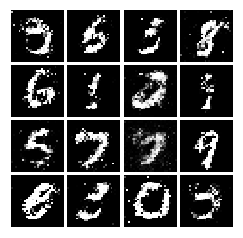


Iter: 3500, D: 1.31, G:0.8645


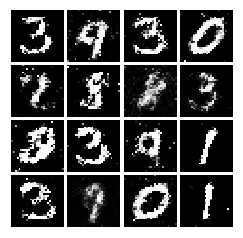


Iter: 3750, D: 1.383, G:0.8554


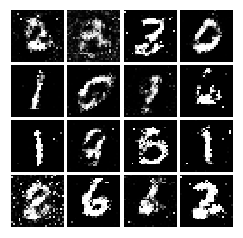

In [9]:
# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = optimizer(D)
G_solver = optimizer(G)
# Run it!
gan_train(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

## LS GAN

In [10]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    N = scores_real.size()
    
    true_labels = Variable(torch.ones(N)).type(dtype)
    
    fake_image_loss = torch.mean((scores_real - true_labels)**2)
    real_image_loss = torch.mean((scores_fake)**2)
    
    loss = (real_image_loss + fake_image_loss) / 2
    
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    N = scores_fake.size()
    
    true_labels = Variable(torch.ones(N)).type(dtype)
    
    loss = 0.5 * ((torch.mean((scores_fake - true_labels)**2)))
    return loss

Iter: 0, D: 0.4919, G:0.4625


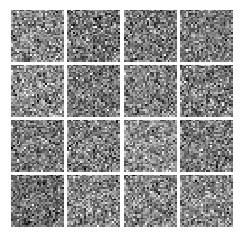


Iter: 250, D: 0.1449, G:0.3169


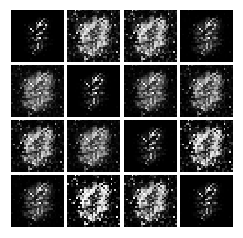


Iter: 500, D: 0.09847, G:0.1378


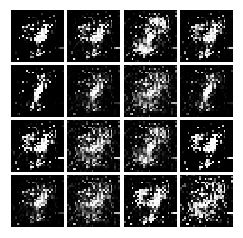


Iter: 750, D: 0.1784, G:0.3773


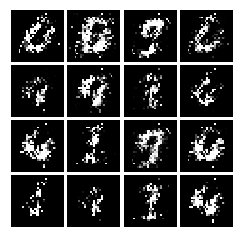


Iter: 1000, D: 0.1502, G:0.4318


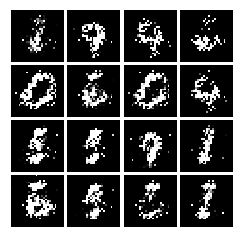


Iter: 1250, D: 0.09653, G:0.4989


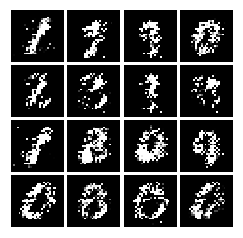


Iter: 1500, D: 0.176, G:0.3643


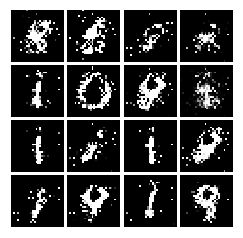


Iter: 1750, D: 0.2412, G:0.2025


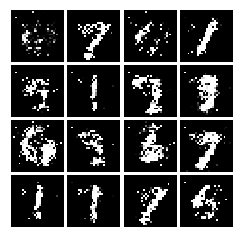


Iter: 2000, D: 0.1502, G:0.2158


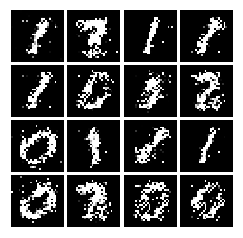


Iter: 2250, D: 0.1996, G:0.2817


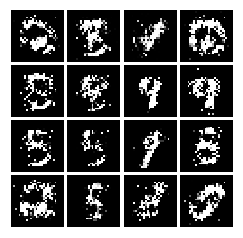


Iter: 2500, D: 0.2463, G:0.1622


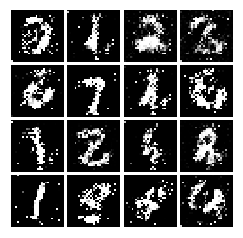


Iter: 2750, D: 0.224, G:0.1825


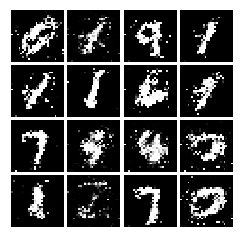


Iter: 3000, D: 0.2174, G:0.1719


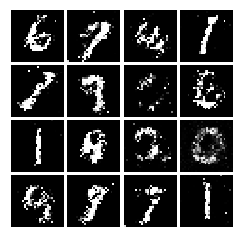


Iter: 3250, D: 0.2315, G:0.1895


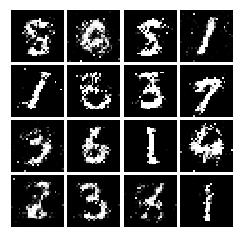


Iter: 3500, D: 0.2449, G:0.1492


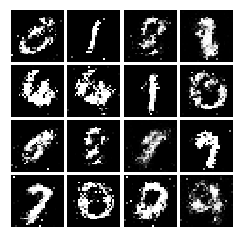


Iter: 3750, D: 0.24, G:0.154


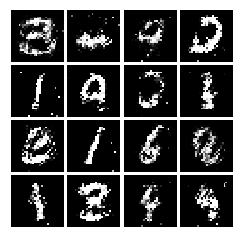

In [12]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = optimizer(D_LS)
G_LS_solver = optimizer(G_LS)

gan_train(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss)

In [13]:
def build_dc_classifier():
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
    return nn.Sequential(
        ###########################
        ######### TO DO ###########
        ###########################
        Unflatten(batch_size, 1, 28, 28),
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Flatten(),
        nn.Linear(4*4*64, 4*4*64),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Linear(4*4*64, 1),
    )

# data = next(enumerate(loader_train))[-1][0].type(dtype)
# b = build_dc_classifier().type(dtype)
# out = b(data)
# print(out.size())

def build_dc_generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """
    return nn.Sequential(
        ###########################
        ######### TO DO ###########
        ###########################
        nn.Linear(noise_dim, 1024),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(1024),
        nn.Linear(1024, 7*7*128),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(7*7*128),
        Unflatten(batch_size, 128, 7, 7),
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1),
        nn.Tanh(),
        Flatten(),
    )

# test_g_gan = build_dc_generator().type(dtype)
# test_g_gan.apply(initialize_weights)

# fake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)
# fake_images = test_g_gan.forward(fake_seed)
# fake_images.size()

Iter: 0, D: 1.396, G:0.2399


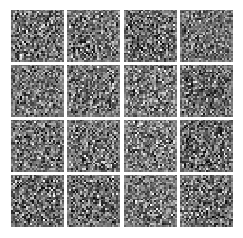


Iter: 250, D: 1.415, G:1.454


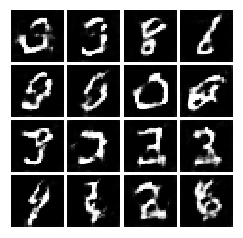


Iter: 500, D: 1.255, G:1.031


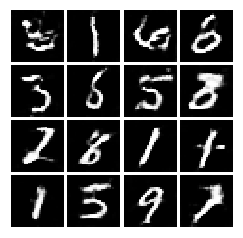


Iter: 750, D: 1.288, G:0.8365


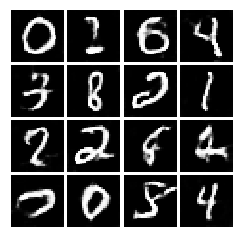


Iter: 1000, D: 1.337, G:0.9366


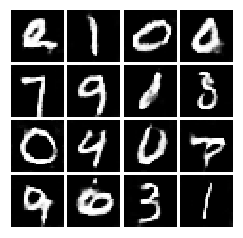


Iter: 1250, D: 1.26, G:1.094


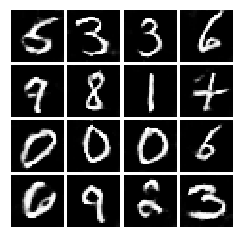


Iter: 1500, D: 1.156, G:0.8972


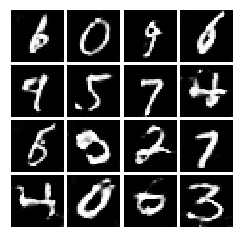


Iter: 1750, D: 1.191, G:0.702


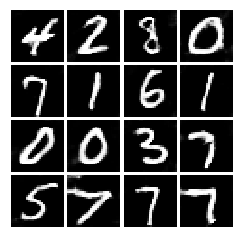

In [15]:
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = optimizer(D_DC)
G_DC_solver = optimizer(G_DC)

gan_train(D_DC, G_DC, D_DC_solver, G_DC_solver, 
          discriminator_loss, generator_loss, num_epochs=5)